In [1]:
library(sits)
set.seed(123)

SITS - satellite image time series analysis.

Loaded sits v1.5.1.
        See ?sits for help, citation("sits") for use in publication.
        Documentation avaliable in https://e-sensing.github.io/sitsbook/.



### Create cube

In [2]:
Sys.setenv("PROJ_LIB"="/usr/share/proj")

In [15]:
#
# General definitions
#

# Dates
y <- "2022"

# Cube directory
cube_dir <- "../data/output/RO/cube/"

# Bands
cube_bands <- c(
  "BLUE", "EVI", "GREEN", "NDVI", "NIR08", "RED", "SWIR16", "SWIR22", "CLOUD"
)

# Hardware - multicores
multicores <- 24

#
# 1. Create cube directory
#
dir.create(cube_dir, recursive = TRUE)

#
# 2. Read ROI
#
tile <- "006008"

#
# 3. Generate cubes
#
# define dates
start_date <- paste0(y, "-01-01")
end_date <- paste0(y, "-12-31")

# load cube
cube <- sits_cube(
    source     = "BDC",
    collection = "LANDSAT-OLI-16D",
    tiles      = tile,
    start_date = start_date,
    end_date   = end_date,
    bands      = cube_bands
)

# define cube directory
cube_dir_year <- paste0(cube_dir, y)

# create cube directory
dir.create(cube_dir_year, recursive = TRUE)

# load cube
cube <- sits_cube_copy(
    cube     = cube,
    multicores = multicores,
    output_dir = cube_dir_year
)

# define cube directory
cube_dir_year_reg <- paste0(cube_dir, y, "_reg")

# create cube directory
dir.create(cube_dir_year_reg, recursive = TRUE)

# regularize cube
cube <- sits_regularize(
    cube       = cube,
    period     = "P1M",
    res        = 30,
    tiles      = cube$tile,
    multicores = multicores,
    output_dir = cube_dir_year_reg
)

Warning message in dir.create(cube_dir, recursive = TRUE):
“'../data/output/cube' already exists”


  |======================================================================| 100%


Warning message in dir.create(cube_dir_year, recursive = TRUE):
“'../data/output/cube/2022' already exists”


  |======================================================================| 100%
  |======================================================================| 100%


In [2]:
# regularize cube
cube <- sits_cube(
    source     = "BDC",
    collection = "LANDSAT-OLI-16D",
    data_dir = "../data/output/cube/2022_reg"
)

  |======================================================================| 100%


In [4]:
print(cube)

# A tibble: 1 × 11
  source collection     satellite sensor tile    xmin   xmax   ymin   ymax crs  
  <chr>  <chr>          <chr>     <chr>  <chr>  <dbl>  <dbl>  <dbl>  <dbl> <chr>
1 BDC    LANDSAT-OLI-1… LANDSAT   OLI    0060… 3.89e6 4.10e6 1.01e7 1.03e7 "PRO…
# ℹ 1 more variable: file_info <list>


### Reading Samples

In [5]:
#
# General definition
#

# Samples
samples_file <- "../data/raw/samples/samples.rds"

# Output directory
base_output_dir <- "../data/output/RO/"

#
# 1. Load samples
#
samples <- readRDS(samples_file)

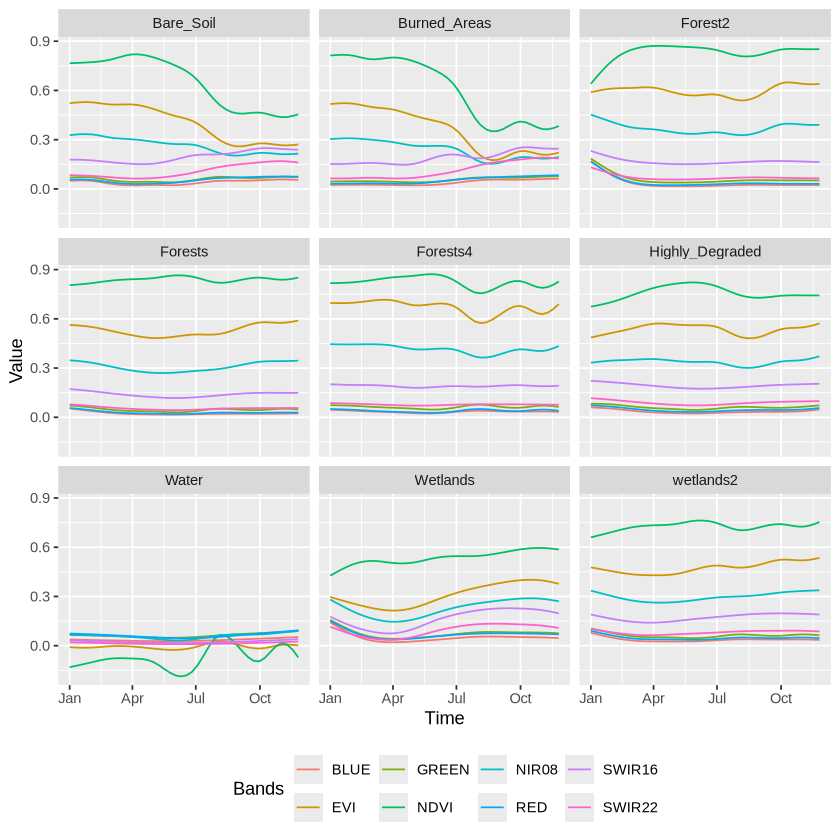

In [6]:
plot(sits_patterns(samples))

### Tunning CNN

In [7]:
#
# 2. Train model
#
tuned_tempcnn <- sits_tuning(
  samples   = samples,
  ml_method = sits_tempcnn(),
  params        = sits_tuning_hparams(
    optimizer   = torch::optim_adamw,
    cnn_kernels = choice(c(3, 3, 3), c(5, 5, 5), c(7, 7, 7)),
    cnn_layers  = choice(c(2^5, 2^5, 2^5), c(2^6, 2^6, 2^6), c(2^7, 2^7, 2^7)),
    opt_hparams = list(
            lr = loguniform(10^-2, 10^-4)
        )
  ),
  trials     = 50,
  multicores = 20,
  progress   = TRUE
)

  |======================================================================| 100%


In [8]:
print(tuned_tempcnn)

# A tibble: 50 × 19
   accuracy kappa acc        samples_validation cnn_layers       cnn_kernels
      <dbl> <dbl> <list>     <list>             <chr>            <chr>      
 1    0.924 0.911 <cnfsnMtr> <NULL>             c(2^7, 2^7, 2^7) c(5, 5, 5) 
 2    0.913 0.898 <cnfsnMtr> <NULL>             c(2^7, 2^7, 2^7) c(3, 3, 3) 
 3    0.911 0.895 <cnfsnMtr> <NULL>             c(2^6, 2^6, 2^6) c(3, 3, 3) 
 4    0.911 0.895 <cnfsnMtr> <NULL>             c(2^7, 2^7, 2^7) c(3, 3, 3) 
 5    0.910 0.894 <cnfsnMtr> <NULL>             c(2^6, 2^6, 2^6) c(7, 7, 7) 
 6    0.908 0.893 <cnfsnMtr> <NULL>             c(2^6, 2^6, 2^6) c(3, 3, 3) 
 7    0.908 0.893 <cnfsnMtr> <NULL>             c(2^6, 2^6, 2^6) c(3, 3, 3) 
 8    0.908 0.893 <cnfsnMtr> <NULL>             c(2^6, 2^6, 2^6) c(3, 3, 3) 
 9    0.908 0.891 <cnfsnMtr> <NULL>             c(2^7, 2^7, 2^7) c(5, 5, 5) 
10    0.907 0.890 <cnfsnMtr> <NULL>             c(2^7, 2^7, 2^7) c(3, 3, 3) 
# ℹ 40 more rows
# ℹ 13 more variables: cnn_dropout_rate

In [12]:
# tuned directory
tuning_dir <- "../data/output/RO/tune/tempcnn/"
dir.create(tuning_dir, recursive = TRUE)

saveRDS(tuned_tempcnn, paste0(tuning_dir, "tempcnn_ro.rds"))

Warning message in dir.create(tuning_dir, recursive = TRUE):
“'../data/output/tune/tempcnn' already exists”


In [7]:
tuned_tempcnn <- readRDS("../data/output/RO/tune/tempcnn/tempcnn_ro.rds")

### Training CNN

In [18]:
tcnn_model <- sits_train(
    samples, sits_tempcnn(
          cnn_layers = c(2^7, 2^7, 2^7),
          cnn_kernels = c(5, 5, 5),
          cnn_dropout_rates = c(0.2, 0.2, 0.2),
          dense_layer_nodes = 256,
          dense_layer_dropout_rate = 0.5,
          epochs = 150,
          batch_size = 64,
          optimizer = torch::optim_adamw,
          opt_hparams = list(lr = 0.000550),
          patience = 20,
          min_delta = 0.01,
          verbose = FALSE
    )
)

In [33]:
environment(tcnn_model)$torch_model

A `luz_module_fitted`
── Time ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
• Total time: 1m 3.7s
• Avg time per training epoch: 1.5s

── Results ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Metrics observed in the last epoch.

ℹ Training:
loss: 0.1437
acc: 0.9467

── Model ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
An `nn_module` containing 566,409 parameters.

── Modules ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
• conv_bn_relu1: <conv1D_batch_no

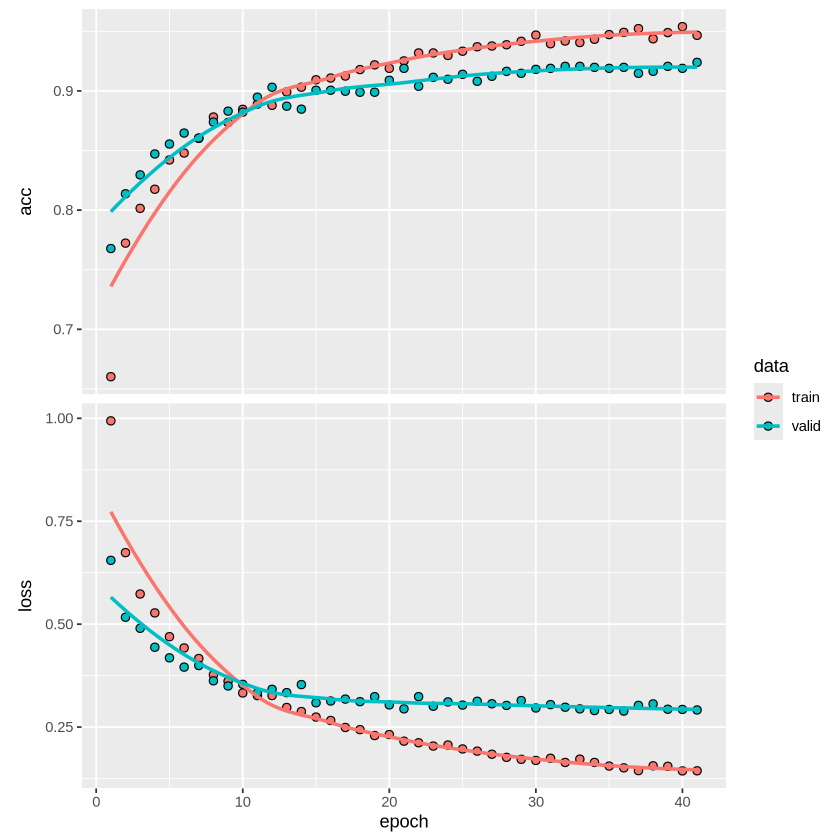

In [19]:
plot(tcnn_model)

In [22]:
#
# 3. Save model
#

base_model_dir <- "../data/output/RO/model/"

tcnn_dir <- paste0(base_model_dir, "tcnn_model.rds")  

# create directory
dir.create(base_model_dir, recursive = TRUE)

# save
saveRDS(tcnn_model, tcnn_dir)

Warning message in dir.create(base_model_dir, recursive = TRUE):
“'../data/output/model' already exists”


In [7]:
tcnn_model <- readRDS("../data/output/RO/model/tcnn_model.rds")

### Tuning LightTAE

In [13]:
tuned_lighttae <- sits_tuning(
  samples   = samples,
  ml_method = sits_lighttae(),
  params        = sits_tuning_hparams(
    optimizer   = torch::optim_adamw,
    opt_hparams = list(
      lr           = loguniform(10^-2, 10^-4),
      weight_decay = loguniform(10^-2, 10^-8)
    )
  ),
  trials     = 50,
  multicores = 20,
  progress   = TRUE
)

  |======================================================================| 100%


In [14]:
# tuned directory
tuning_dir <- "../data/output/RO/tune/lighttae/"
dir.create(tuning_dir, recursive = TRUE)

saveRDS(tuned_lighttae, paste0(tuning_dir, "lighttae_ro.rds"))

In [3]:
tuned_lighttae <- readRDS("../data/output/RO/tune/lighttae/lighttae_ro.rds")

In [25]:
print(tuned_lighttae[1,]$opt_hparams)

[[1]]
# A tibble: 1 × 2
       lr weight_decay
    <dbl>        <dbl>
1 0.00147     0.000246



### Training LightTAE

In [27]:
lighttae_model <- sits_train(
    samples, sits_lighttae(
      epochs = 150,
      batch_size = 128,
      optimizer = torch::optim_adamw,
      opt_hparams = list(lr = 0.00147, weight_decay = 0.000246),
      lr_decay_epochs = 50L,
      patience = 20L,
      min_delta = 0.01,
      verbose = FALSE
    )
)

In [32]:
environment(lighttae_model)$torch_model

A `luz_module_fitted`
── Time ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
• Total time: 1m 29.8s
• Avg time per training epoch: 1.5s

── Results ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Metrics observed in the last epoch.

ℹ Training:
loss: 0.1252
acc: 0.9643

── Model ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
An `nn_module` containing 127,867 parameters.

── Modules ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
• spatial_encoder: <torch_pixel_

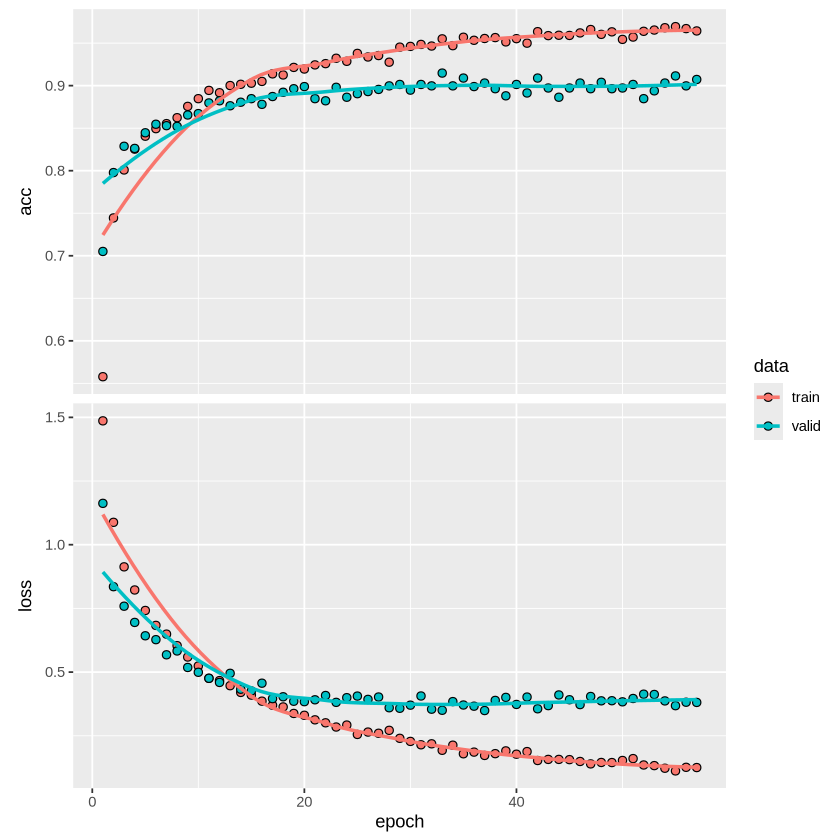

In [28]:
plot(lighttae_model)

In [29]:
#
# 3. Save model
#

ltae_dir <- paste0(base_model_dir, "ltae_model.rds")  

# save
saveRDS(lighttae_model, ltae_dir)

In [2]:
lighttae_model <- readRDS("../data/output/RO/model/ltae_model.rds")

### Pixel-based classification - TCNN

In [35]:
# Output directory
output_dir <- "../data/output/RO/classifications/tccn"

# Version
results_version <- "tcnn-8cls"

#
# 1. Create directory
#
dir.create(output_dir, recursive = TRUE)

#
# 4. Classify
#

# classify
probs_cube <- sits_classify(
    data       = cube,
    ml_model   = tcnn_model,
    memsize    = 54,
    gpu_memory = 10,
    multicores = 24,
    output_dir = output_dir,
    version    = results_version,
    progress   = TRUE,
    verbose    = TRUE
)

# smooth
probs_bayes <- sits_smooth(
    cube           = probs_cube,
    window_size    = 9,
    neigh_fraction = 0.5,
    smoothness     = c(10, 10, 10, 10, 10, 10, 10, 10, 10),
    memsize        = 60,
    multicores     = 24,
    output_dir     = output_dir,
    version        = results_version
)

# generate map
class_cube <- sits_label_classification(
    cube       = probs_bayes,
    memsize    = 60,
    multicores = 24,
    output_dir = output_dir,
    version    = results_version
)

Warning message in dir.create(output_dir, recursive = TRUE):
“'../data/output/classifications/tccn' already exists”
using blocks of size 1024 x 7040

recovery mode: data already exists. To produce new data, change output_dir or version



task finished at2024-12-03 14:55:44.473776

elapsed time for task0.01 secs



  |======================================================================| 100%


### Pixel-based classification - LightTAE

In [36]:
# Output directory
output_dir <- "../data/output/RO/classifications/lighttae"

# Version
results_version <- "lighttaeb-8cls"

#
# 1. Create directory
#
dir.create(output_dir, recursive = TRUE)

#
# 4. Classify
#
probs_cube <- sits_classify(
    data       = cube,
    ml_model   = lighttae_model,
    memsize    = 54,
    gpu_memory = 10,
    multicores = 24,
    output_dir = output_dir,
    version    = results_version,
    progress   = TRUE,
    verbose    = TRUE
)

# smooth
probs_bayes <- sits_smooth(
    cube           = probs_cube,
    window_size    = 9,
    neigh_fraction = 0.5,
    smoothness     = c(10, 10, 10, 10, 10, 10, 10, 10, 10),
    memsize        = 60,
    multicores     = 24,
    output_dir     = output_dir,
    version        = results_version
)

# generate map
class_cube <- sits_label_classification(
    cube       = probs_bayes,
    memsize    = 60,
    multicores = 24,
    output_dir = output_dir,
    version    = results_version
)

using blocks of size 1024 x 7040

Starting classification of tile '006008' at 2024-12-03 15:08:31.714206



  |======================================================================| 100%


Tile '006008' finished at 2024-12-03 15:24:42.58268

Elapsed time of 16.18 mins





task finished at2024-12-03 15:24:42.78521

elapsed time for task16.18 mins



  |======================================================================| 100%


### Apply Spatial-temporal segmentation

In [4]:
segment_dir <- "../data/output/RO/segment/"
segments <- sits_segment(
  cube = cube,
  seg_fn = sits_slic(
    step = 20,
    compactness = 1,
    dist_fun = "euclidean",
    iter = 20,
    minarea = 20
  ),
  output_dir = segment_dir,
  memsize    = 30,
  multicores = 12
)

recovery mode: data already exists. To produce new data, change output_dir or version



### Object-based classification - TCNN

In [10]:
# Output directory
output_dir <- "../data/output/RO/segment/tcnn"

# Version
results_version <- "tcnn-8cls-segments"

#
# 1. Create directory
#
dir.create(output_dir, recursive = TRUE)

#
# 4. Classify
#
probs_cube <- sits_classify(
    data       = segments_20LMR,
    ml_model   = tcnn_model,
    n_sam_pol  = 40,
    memsize    = 30,
    gpu_memory = 10,
    multicores = 24,
    output_dir = output_dir,
    version    = results_version,
    progress   = TRUE,
    verbose    = TRUE
)

# generate map
class_cube <- sits_label_classification(
    cube       = probs_cube,
    memsize    = 30,
    multicores = 12,
    output_dir = output_dir,
    version    = results_version
)

Warning message in dir.create(output_dir, recursive = TRUE):
“'../data/output/RO/segment/tcnn' already exists”


  |                                                                      |   0%

Cannot preload entire working area of 89717760 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89717760 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89717760 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89717760 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89717760 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89717760 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89717760 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89717760 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%
  |==========                                                            |  14%

Cannot preload entire working area of 89717760 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89717760 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89717760 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89717760 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89717760 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89717760 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89717760 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89717760 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%
  |====================                                                  |  29%

Cannot preload entire working area of 89379840 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89379840 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89379840 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89379840 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89379840 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89379840 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89379840 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89379840 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%
  |==============================                                        |  43%

Cannot preload entire working area of 89633280 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89633280 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89633280 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89633280 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89633280 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89633280 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89633280 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89633280 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%
  |========================================                              |  57%

Cannot preload entire working area of 88957440 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 88957440 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 88957440 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 88957440 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 88957440 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 88957440 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 88957440 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 88957440 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%
  |==================================================                    |  71%

Cannot preload entire working area of 89210880 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89210880 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89210880 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89210880 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89210880 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89210880 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89210880 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89210880 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%
  |============================================================          |  86%

Cannot preload entire working area of 75609600 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 75609600 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 75609600 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 75609600 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 75609600 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 75609600 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 75609600 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 75609600 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%
  |======================================================================| 100%


### Object-based classification - LightTae

In [8]:
# Output directory
output_dir <- "../data/output/RO/segment/ltae"

# Version
results_version <- "ltae-8cls-segments"

#
# 1. Create directory
#
dir.create(output_dir, recursive = TRUE)

#
# 4. Classify
#
probs_cube <- sits_classify(
    data       = segments,
    ml_model   = lighttae_model,
    n_sam_pol  = 40,
    memsize    = 30,
    gpu_memory = 10,
    multicores = 24,
    output_dir = output_dir,
    version    = results_version,
    progress   = FALSE,
    verbose    = FALSE
)

# generate map
class_cube <- sits_label_classification(
    cube       = probs_cube,
    memsize    = 30,
    multicores = 12,
    output_dir = output_dir,
    version    = results_version
)

Warning message in dir.create(output_dir, recursive = TRUE):
“'../data/output/RO/segment/ltae' already exists”
Cannot preload entire working area of 89633280 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89633280 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89633280 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89633280 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89633280 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89633280 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89633280 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89633280 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 88957440 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 88957440 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 88957440 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 88957440 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 88957440 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 88957440 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 88957440 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 88957440 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89210880 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89210880 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89210880 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89210880 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89210880 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89210880 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89210880 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 89210880 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 75609600 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 75609600 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 75609600 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 75609600 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 75609600 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 75609600 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 75609600 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


Cannot preload entire working area of 75609600 cells with max_cells_in_memory = 3e+07. Raster values will be read for each feature individually.



  |======================================================================| 100%


In [37]:
samples_val <- sf::st_read("../data/raw/RO/validation/validation_pts.gpkg")

print(samples_val)samples_val <- sf::st_read("../data/raw/RO/validation/validation_pts.gpkg")

print(samples_val)

Reading layer `validation_pts' from data source 
  `/home/jovyan/experiment-geo-dl/data/raw/RO/validation/validation_pts.gpkg' 
  using driver `GPKG'
Simple feature collection with 319 features and 4 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -64.29124 ymin: -11.3813 xmax: -62.30947 ymax: -9.485726
Geodetic CRS:  WGS 84
Simple feature collection with 319 features and 4 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -64.29124 ymin: -11.3813 xmax: -62.30947 ymax: -9.485726
Geodetic CRS:  WGS 84
First 10 features:
   class LTAE1 RFor1 TCNN1                        geom
1  CR_SE     1     1     1  POINT (-62.6737 -11.01375)
2  CR_SE     1     1     1 POINT (-64.06948 -10.21668)
3  CR_SE     1     1     1 POINT (-63.97642 -10.08569)
4  CR_SE     1     1     1 POINT (-62.40085 -9.773946)
5  CR_SE     1     1     1 POINT (-62.40983 -10.49376)
6  CR_SE     1     1     1 POINT (-62.77443 -10.84041)
7  CR_SE     1     1     1 POINT (-62.91036 -9.543613)

### Validation pixel-based - TCNN

In [8]:
labels <- sits_labels(tcnn_model)
names(labels) <- seq_len(length(labels))

In [11]:
class_tcnn <- sits_cube(
    source     = "BDC",
    collection = "LANDSAT-OLI-16D",
    data_dir   = "../data/output/RO/classifications/tccn/",
    bands      = "class",
    labels     = labels,
    version    = "tcnn-8cls"
)

  |======================================================================| 100%


### Mask classes 

In [31]:
out_dir <- "../data/output/RO/validation/tcnn"
dir.create(out_dir, recursive = TRUE)

masked_tcnn <- sits_reclassify(
    cube = class_tcnn,
    mask = class_tcnn,
    rules = list(
        #"deforestation" = cube %in% c("Bare_Soil", "Burned_Areas", "Highly_Degraded"),
        "forest" = cube %in% c("Forest2", "Forests", "Forests4"),
        "water" = cube %in% c("Water", "Wetlands", "wetlands2")
    ),
    memsize    = 54,
    multicores = 24,
    output_dir = out_dir
)

Warning message in dir.create(out_dir, recursive = TRUE):
“'../data/output/RO/validation/tcnn' already exists”


In [33]:
sits_labels(masked_tcnn)

1                 2                 6                10 
      "Bare_Soil"    "Burned_Areas" "Highly_Degraded"          "forest" 
               11 
          "water"

In [34]:
samples_val <- samples_val |>
  dplyr::mutate(
    label = dplyr::case_when(
      #class %in% c("CR_QM", "CR_SE", "CR_VG")  ~ "deforestation",
      #class %in% c("CR_QM", "CR_SE", "CR_VG")  ~ "deforestation",
      class == "CR_QM" ~ "Burned_Areas",
      class == "CR_SE" ~ "Bare_Soil",
      class == "CR_VG" ~ "Highly_Degraded",
      class %in% c("For", "MSFor")  ~ "forest",
      class %in% c("water") ~ "water"
    )
)

In [35]:
acc_tcnn <- sits_accuracy(
    data = masked_tcnn,
    validation = samples_val[, "label"],
    
)

In [36]:
acc_tcnn

Area Weighted Statistics
Overall Accuracy = 0.92

Area-Weighted Users and Producers Accuracy
                User Producer
Bare_Soil       0.88     0.99
Burned_Areas    0.67     0.14
Highly_Degraded 0.69     0.37
forest          0.97     1.00
water           0.88     1.00

Mapped Area x Estimated Area (ha)
                Mapped Area (ha) Error-Adjusted Area (ha) Conf Interval (ha)
Bare_Soil             2221696.44               1984541.43          133939.28
Burned_Areas            56276.73                270067.96          121570.89
Highly_Degraded        106621.38                198142.40           85669.75
forest                2001673.53               1942800.78           50989.88
water                   74275.92                 64991.43           18197.60

### Validation pixel-based - LightTAE

In [38]:
labels <- sits_labels(lighttae_model)
names(labels) <- seq_len(length(labels))

In [39]:
class_ltae <- sits_cube(
    source     = "BDC",
    collection = "LANDSAT-OLI-16D",
    data_dir   = "../data/output/RO/classifications/lighttae/",
    bands      = "class",
    labels     = labels,
    version    = "lighttaeb-8cls"
)

  |======================================================================| 100%


In [41]:
sits_labels(class_ltae)

1                 2                 3                 4 
      "Bare_Soil"    "Burned_Areas"         "Forest2"         "Forests" 
                5                 6                 7                 8 
       "Forests4" "Highly_Degraded"           "Water"        "Wetlands" 
                9 
      "wetlands2"

### Mask classes 

In [40]:
out_dir <- "../data/output/RO/validation/lighttae"
dir.create(out_dir, recursive = TRUE)

masked_ltae <- sits_reclassify(
    cube = class_ltae,
    mask = class_ltae,
    rules = list(
        #"deforestation" = cube %in% c("Bare_Soil", "Burned_Areas", "Highly_Degraded"),
        "forest" = cube %in% c("Forest2", "Forests", "Forests4"),
        "water" = cube %in% c("Water", "Wetlands", "wetlands2")
    ),
    memsize    = 54,
    multicores = 24,
    output_dir = out_dir
)

In [42]:
sits_labels(masked_ltae)

1                 2                 6                10 
      "Bare_Soil"    "Burned_Areas" "Highly_Degraded"          "forest" 
               11 
          "water"

In [43]:
samples_val <- samples_val |>
  dplyr::mutate(
    label = dplyr::case_when(
      #class %in% c("CR_QM", "CR_SE", "CR_VG")  ~ "deforestation",
      #class %in% c("CR_QM", "CR_SE", "CR_VG")  ~ "deforestation",
      class == "CR_QM" ~ "Burned_Areas",
      class == "CR_SE" ~ "Bare_Soil",
      class == "CR_VG" ~ "Highly_Degraded",
      class %in% c("For", "MSFor")  ~ "forest",
      class %in% c("water") ~ "water"
    )
)

In [44]:
acc_ltae <- sits_accuracy(
    data = masked_ltae,
    validation = samples_val[, "label"],
)

In [45]:
acc_ltae

Area Weighted Statistics
Overall Accuracy = 0.9

Area-Weighted Users and Producers Accuracy
                User Producer
Bare_Soil       0.88     0.99
Burned_Areas    0.83     0.17
Highly_Degraded 0.62     0.22
forest          0.93     1.00
water           1.00     1.00

Mapped Area x Estimated Area (ha)
                Mapped Area (ha) Error-Adjusted Area (ha) Conf Interval (ha)
Bare_Soil             2221548.66                1970922.6          137896.06
Burned_Areas            57223.08                 277015.3          121125.86
Highly_Degraded         91884.69                 266990.4          108792.45
forest                1975415.13                1831143.2           75721.89
water                  114472.44                 114472.4               0.00

### Validation object-based - TCNN

In [72]:
class_object_tcnn <- sf::st_read("../data/output/RO/segment/tcnn/LANDSAT_OLI_006008_2022-01-01_2022-12-01_class_tcnn-8cls-segments.gpkg")
rast_template <- terra::rast("../data/output/RO/classifications/tccn/LANDSAT_OLI_006008_2022-01-01_2022-12-01_class_tcnn-8cls.tif")

Reading layer `LANDSAT_OLI_006008_2022-01-01_2022-12-01_class_tcnn-8cls-segments' from data source `/home/jovyan/experiment-geo-dl/data/output/RO/segment/tcnn/LANDSAT_OLI_006008_2022-01-01_2022-12-01_class_tcnn-8cls-segments.gpkg' 
  using driver `GPKG'
Simple feature collection with 131364 features and 14 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 3891200 ymin: 10052800 xmax: 4102400 ymax: 10264000
Projected CRS: +proj=aea +lat_0=-12 +lon_0=-54 +lat_1=-2 +lat_2=-22 +x_0=5000000 +y_0=10000000 +ellps=GRS80 +units=m +no_defs


In [73]:
class_object_tcnn <- class_object_tcnn |>
  dplyr::mutate(
    label_val = dplyr::case_when(
      class == "Bare_Soil" ~ 1,
      class == "Burned_Areas" ~ 2,
      class == "Forest2" ~ 3,
      class == "Forests" ~ 4,
      class == "Forests4" ~ 5,
      class == "Highly_Degraded" ~ 6,
      class == "Water" ~ 7,
      class == "Wetlands" ~ 8,
      class == "wetlands2" ~ 9
    )
)

In [75]:
rasterize_tcnn <- terra::rasterize(x = terra::vect(class_object_tcnn), y = rast_template, field = "label_val")

In [78]:
terra::writeRaster(
    x = rasterize_tcnn, 
    filename = "../data/output/RO/segment/tcnn/LANDSAT_OLI_006008_2022-01-01_2022-12-01_class_tcnn-8cls-segments-rasterize.tif",
    gdal = c("COMPRESS=LZW", "PREDICTOR=2", "BIGTIFF=YES",
             "TILED=YES", "BLOCKXSIZE=512", "BLOCKYSIZE=512"),
    datatype = "INT1U"
)

In [114]:
class_tcnn <- sits_cube(
    source     = "BDC",
    collection = "LANDSAT-OLI-16D",
    data_dir   = "../data/output/RO/segment/tcnn/",
    bands      = "class",
    labels     = labels,
    version    = "tcnn-8cls-segments-rasterize"
)

  |======================================================================| 100%


In [101]:
print(class_tcnn)

# A tibble: 1 × 12
  source collection     satellite sensor tile    xmin   xmax   ymin   ymax crs  
  <chr>  <chr>          <chr>     <chr>  <chr>  <dbl>  <dbl>  <dbl>  <dbl> <chr>
1 BDC    LANDSAT-OLI-1… LANDSAT   OLI    0060… 3.89e6 4.10e6 1.01e7 1.03e7 "PRO…
# ℹ 2 more variables: labels <list>, file_info <list>


In [115]:
masked_tcnn <- sits_reclassify(
    cube = class_tcnn,
    mask = class_tcnn,
    rules = list(
        #"deforestation" = cube %in% c("Bare_Soil", "Burned_Areas", "Highly_Degraded"),
        "forest" = cube %in% c("Forest2", "Forests", "Forests4"),
        "water" = cube %in% c("Water", "Wetlands", "wetlands2")
    ),
    memsize    = 54,
    multicores = 24,
    output_dir = "../data/output/RO/segment/tcnn/",
    version = "tcnn-8cls-segments-rasterize-reclassified"
)

In [116]:
samples_val <- samples_val |>
  dplyr::mutate(
    label = dplyr::case_when(
      #class %in% c("CR_QM", "CR_SE", "CR_VG")  ~ "deforestation",
      #class %in% c("CR_QM", "CR_SE", "CR_VG")  ~ "deforestation",
      class == "CR_QM" ~ "Burned_Areas",
      class == "CR_SE" ~ "Bare_Soil",
      class == "CR_VG" ~ "Highly_Degraded",
      class %in% c("For", "MSFor")  ~ "forest",
      class %in% c("water") ~ "water"
    )
)

In [117]:
acc_tcnn <- sits_accuracy(
    data = masked_tcnn,
    validation = samples_val[, "label"],
)

In [118]:
acc_tcnn

Area Weighted Statistics
Overall Accuracy = 0

Area-Weighted Users and Producers Accuracy
                User Producer
Bare_Soil       0.00     0.00
Burned_Areas    0.00     0.00
Highly_Degraded 0.00     0.00
forest          0.04     0.01
water           0.00     0.00

Mapped Area x Estimated Area (ha)
                Mapped Area (ha) Error-Adjusted Area (ha) Conf Interval (ha)
Bare_Soil              203056.38               1458497.50          227734.99
Burned_Areas            55581.03                323889.60          124199.90
Highly_Degraded          9382.77                314832.02          126967.37
forest                 361199.97               2331380.29          233679.41
water                 3831323.85                 31944.59           30335.47

### Validation object-based - LighTAE

In [89]:
class_object_ltae <- sf::st_read("../data/output/RO/segment/ltae/LANDSAT_OLI_006008_2022-01-01_2022-12-01_class_ltae-8cls-segments.gpkg")
rast_template <- terra::rast("../data/output/RO/classifications/lighttae/LANDSAT_OLI_006008_2022-01-01_2022-12-01_class_lighttaeb-8cls.tif")

Reading layer `LANDSAT_OLI_006008_2022-01-01_2022-12-01_class_ltae-8cls-segments' from data source `/home/jovyan/experiment-geo-dl/data/output/RO/segment/ltae/LANDSAT_OLI_006008_2022-01-01_2022-12-01_class_ltae-8cls-segments.gpkg' 
  using driver `GPKG'
Simple feature collection with 131364 features and 14 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: 3891200 ymin: 10052800 xmax: 4102400 ymax: 10264000
Projected CRS: +proj=aea +lat_0=-12 +lon_0=-54 +lat_1=-2 +lat_2=-22 +x_0=5000000 +y_0=10000000 +ellps=GRS80 +units=m +no_defs


In [90]:
class_object_ltae <- class_object_ltae |>
  dplyr::mutate(
    label_val = dplyr::case_when(
      class == "Bare_Soil" ~ 1,
      class == "Burned_Areas" ~ 2,
      class == "Forest2" ~ 3,
      class == "Forests" ~ 4,
      class == "Forests4" ~ 5,
      class == "Highly_Degraded" ~ 6,
      class == "Water" ~ 7,
      class == "Wetlands" ~ 8,
      class == "wetlands2" ~ 9
    )
)

In [91]:
rasterize_ltae <- terra::rasterize(x = terra::vect(class_object_ltae), y = rast_template, field = "label_val")

In [92]:
terra::writeRaster(
    x = rasterize_ltae, 
    filename = "../data/output/RO/segment/ltae/LANDSAT_OLI_006008_2022-01-01_2022-12-01_class_ltae-8cls-segments-rasterize.tif",
    gdal = c("COMPRESS=LZW", "PREDICTOR=2", "BIGTIFF=YES",
             "TILED=YES", "BLOCKXSIZE=512", "BLOCKYSIZE=512"),
    datatype = "INT1U"
)

In [104]:
class_ltae <- sits_cube(
    source     = "BDC",
    collection = "LANDSAT-OLI-16D",
    data_dir   = "../data/output/RO/segment/ltae/",
    bands      = "class",
    labels     = labels,
    version    = "ltae-8cls-segments-rasterize"
)

  |======================================================================| 100%


In [106]:
masked_ltae <- sits_reclassify(
    cube = class_ltae,
    mask = class_ltae,
    rules = list(
        #"deforestation" = cube %in% c("Bare_Soil", "Burned_Areas", "Highly_Degraded"),
        "forest" = cube %in% c("Forest2", "Forests", "Forests4"),
        "water" = cube %in% c("Water", "Wetlands", "wetlands2")
    ),
    memsize    = 54,
    multicores = 24,
    output_dir = "../data/output/RO/segment/ltae/",
    version = "ltae-8cls-segments-rasterize-reclassified"
)

In [83]:
samples_val <- samples_val |>
  dplyr::mutate(
    label = dplyr::case_when(
      #class %in% c("CR_QM", "CR_SE", "CR_VG")  ~ "deforestation",
      #class %in% c("CR_QM", "CR_SE", "CR_VG")  ~ "deforestation",
      class == "CR_QM" ~ "Burned_Areas",
      class == "CR_SE" ~ "Bare_Soil",
      class == "CR_VG" ~ "Highly_Degraded",
      class %in% c("For", "MSFor")  ~ "forest",
      class %in% c("water") ~ "water"
    )
)

In [112]:
acc_ltae <- sits_accuracy(
    data = masked_ltae,
    validation = samples_val[, "label"],
)

In [113]:
acc_ltae

Area Weighted Statistics
Overall Accuracy = 0.89

Area-Weighted Users and Producers Accuracy
                User Producer
Bare_Soil       0.85     0.99
Burned_Areas    0.85     0.13
Highly_Degraded 0.67     0.14
forest          0.93     0.99
water           1.00     1.00

Mapped Area x Estimated Area (ha)
                Mapped Area (ha) Error-Adjusted Area (ha) Conf Interval (ha)
Bare_Soil             2248012.35                1944601.6          147695.66
Burned_Areas            40675.68                 255477.8          121187.44
Highly_Degraded         58250.16                 276491.4          117064.32
forest                2043667.71                1914035.1           78657.86
water                   69938.10                  69938.1               0.00